# Geospatial Analysis Problems
## Problem 1

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType

spark = SparkSession.builder.getOrCreate()

requests = spark.read.csv('./data/DataSample.csv', header = True)
requests = requests.withColumn('Latitude',requests[5].cast(DoubleType())).withColumn('Longitude',requests[6].cast(DoubleType()))

clean = requests.dropDuplicates([' TimeSt', 'Latitude', 'Longitude'])

In [2]:
requests.count()

22025

In [3]:
clean.count()

19999

The number of total entries is 22025.

After filtering out questionable request records, there are 19999 entries.

In [4]:
clean.coalesce(1).write.option("header", "true").mode('overwrite').csv("./results/problem1")

Cleaned CSV stored to ./results/problem1

## Problem 2

First, create functions to calculate distance between points, and to find the closest POI

In [5]:
from math import radians, cos, sin, asin, sqrt, inf

# Source, https://www.geeksforgeeks.org/program-distance-two-points-earth/
def distance(lat1,lon1,lat2,lon2):
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
    return 2 * asin(sqrt(a)) * 6371

poi = spark.read.csv('./data/POIList.csv', header = True)
poi = poi.withColumn(' Latitude',poi[1].cast(DoubleType())).withColumn('Longitude',poi[2].cast(DoubleType()))
poiIt = poi.rdd.collect()

def closest(lat1,lon1):
    lat1 = float(lat1)
    lon1 = float(lon1)
    
    best = inf
    bestPOI = None
    for p in poiIt:
        d = distance(lat1,lon1,float(p[" Latitude"]),float(p["Longitude"]))
        if d<best:
            best = d
            bestPOI = p[0]
    
    return (bestPOI,best)

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

schema = StructType([StructField("POIID",StringType(),True),StructField("Distance",IntegerType(),True)])

closestUDF = udf(lambda x,y: closest(x,y),schema)

withClosestPOI = requests.rdd.map(lambda x: x+closest(x[5],x[6]))\
                    .toDF(["_ID","TimeSt","Country","Province","City","Latitude","Longitude","POIID","POIDistance"])

withClosestPOI.show()

+-------+--------------------+-------+--------+------------+--------+---------+-----+-----------------+
|    _ID|              TimeSt|Country|Province|        City|Latitude|Longitude|POIID|      POIDistance|
+-------+--------------------+-------+--------+------------+--------+---------+-----+-----------------+
|4516516|2017-06-21 00:00:...|     CA|      ON|    Waterloo|43.49347|-80.49123| POI3|593.4134412324521|
|4516547|2017-06-21 18:00:...|     CA|      ON|      London| 42.9399| -81.2709| POI3|677.3096549572073|
|4516550|2017-06-21 15:00:...|     CA|      ON|      Guelph| 43.5776| -80.2201| POI3|569.6477373989126|
|4516600|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773| POI3|634.7339960242027|
|4516613|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773| POI3|634.7339960242027|
|4516693|2017-06-21 14:00:...|     CA|      ON|   Kitchener| 43.4381| -80.5099| POI3|597.3787433319694|
|4516771|2017-06-21 10:00:...|     CA|      ON|      Sarnia|  42

New columns with the closest POI and the distance are added.

In [7]:
withClosestPOI.coalesce(1).write.option("header", "true").mode('overwrite').csv("./results/problem2")

The resulting data is saved to ./results/problem2

## Problem 3
### Part 1

In [8]:
from pyspark.sql.functions import count,mean,stddev,max,col
from math import pi

analysis = withClosestPOI.groupBy("POIID").agg(\
        count("*").alias("count"),\
        mean("POIDistance").alias("mean (km)"),\
        stddev("POIDistance").alias("stddev (km)"),\
        max("POIDistance").alias("circle_radius (km)")\
    )
analysis.show()

+-----+-----+------------------+------------------+------------------+
|POIID|count|         mean (km)|       stddev (km)|circle_radius (km)|
+-----+-----+------------------+------------------+------------------+
| POI4|  532|483.22387001997924|1445.2975716153032| 9349.572770487368|
| POI1|10705| 302.8811473902404|431.16610012487354|11531.820831836454|
| POI3|10788| 451.4267143496232|223.12083008865193|1474.5809620285697|
+-----+-----+------------------+------------------+------------------+



### Part 2

In [9]:
analysis = analysis.withColumn("area (km^2)",pi*col("circle_radius (km)")*col("circle_radius (km)"))
analysis = analysis.withColumn("density (requests/km^2)",col("count")/col("circle_radius (km)")).sort("POIID")

analysis.show()

+-----+-----+------------------+------------------+------------------+-------------------+-----------------------+
|POIID|count|         mean (km)|       stddev (km)|circle_radius (km)|        area (km^2)|density (requests/km^2)|
+-----+-----+------------------+------------------+------------------+-------------------+-----------------------+
| POI1|10705| 302.8811473902404|431.16610012487354|11531.820831836454|4.177780756102357E8|     0.9283009297583076|
| POI3|10788| 451.4267143496232|223.12083008865193|1474.5809620285697|  6831044.551100181|      7.315976726811277|
| POI4|  532|483.22387001997924|1445.2975716153032| 9349.572770487368|2.746207855453352E8|   0.056900995698894195|
+-----+-----+------------------+------------------+------------------+-------------------+-----------------------+



Note that the reason none of the requests are closest to POI2 is simply because POI1 and POI2 are at the exact same location.

In [10]:
import pandas

p = poi.toPandas()
a = analysis.toPandas()

a.loc[3]=a.loc[2]
a.loc[2]=a.loc[1]
a.loc[1]=a.loc[0]

p['rad'] = a['circle_radius (km)']
p


,POIID,Latitude,Longitude,rad
0,POI1,53.546167,-113.485734,11531.820832
1,POI2,53.546167,-113.485734,11531.820832
2,POI3,45.521629,-73.566024,1474.580962
3,POI4,45.224830,-63.232729,9349.572770


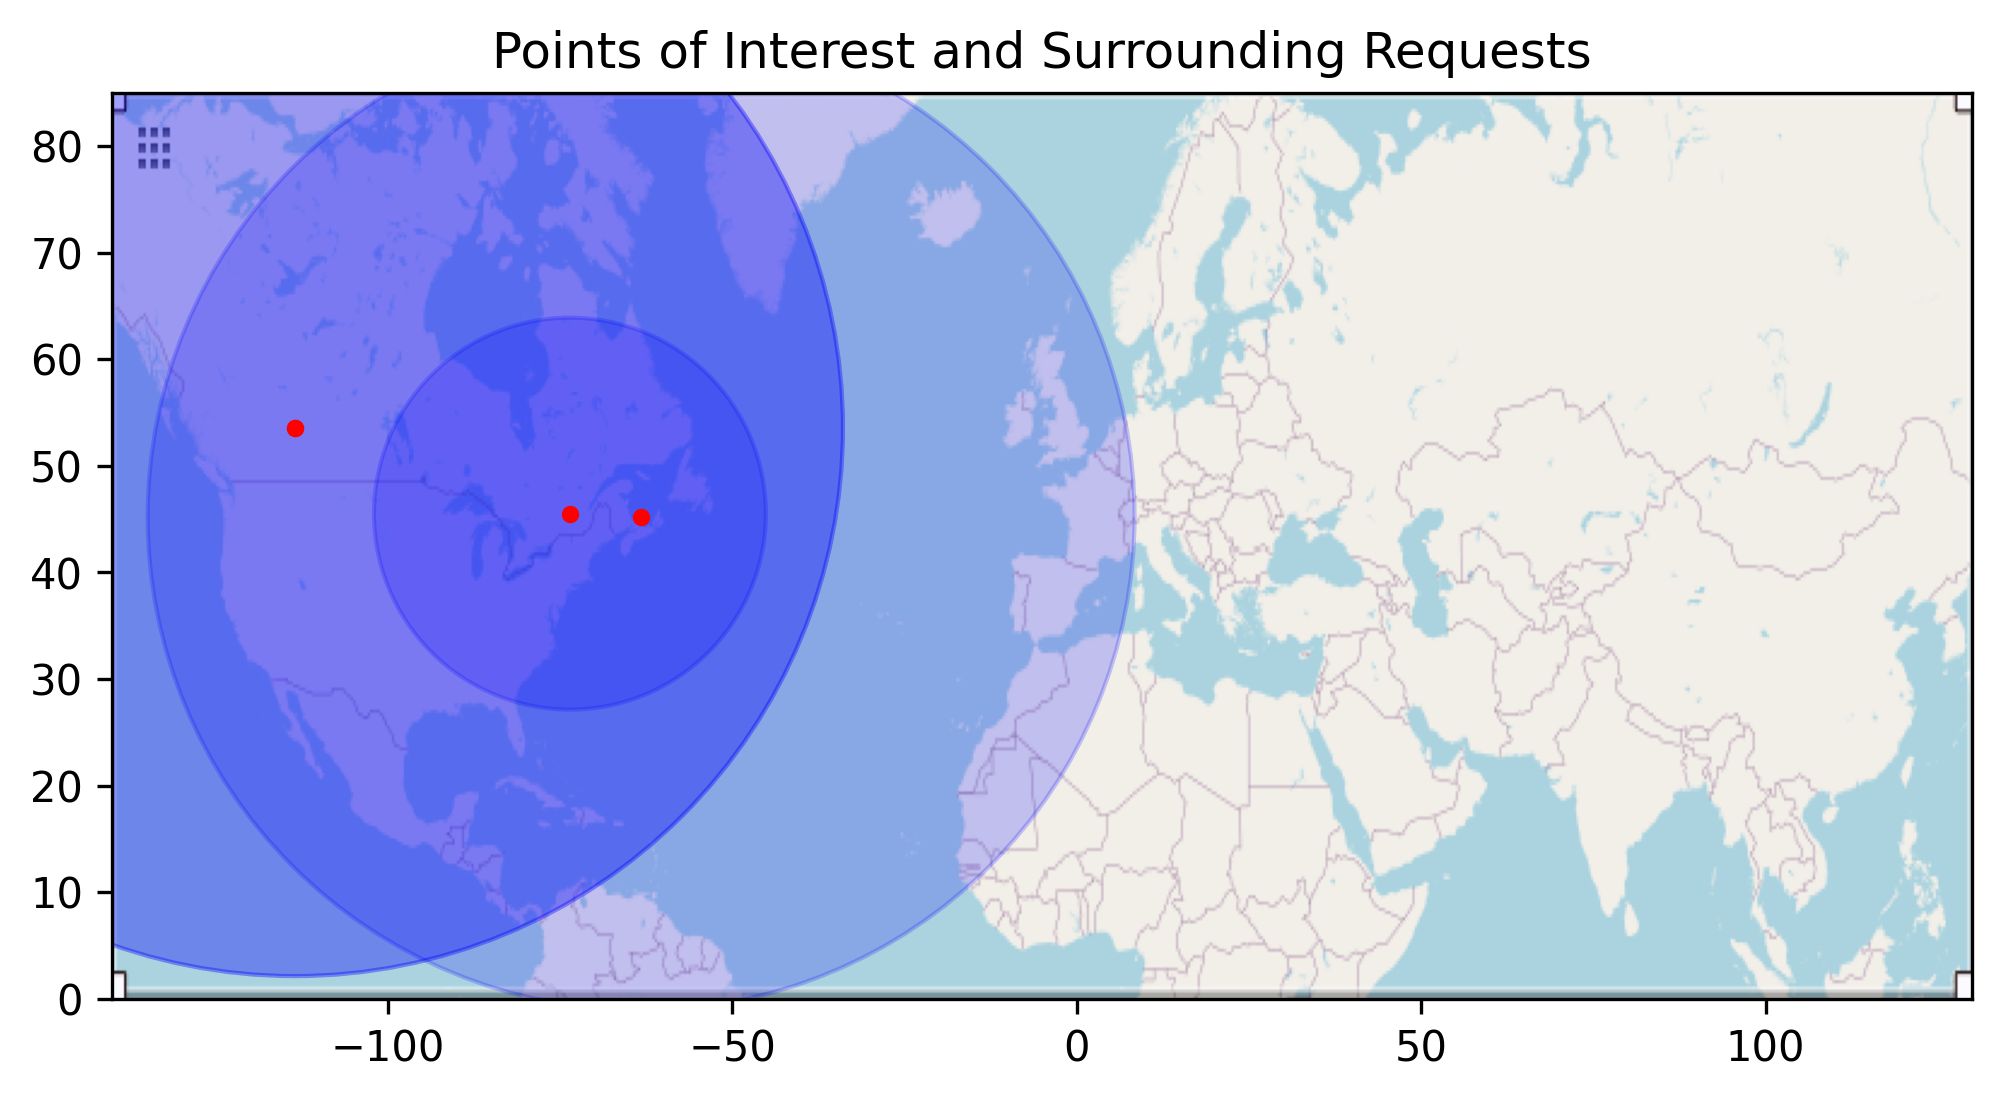

In [11]:
import matplotlib.pyplot as plt

mapImg = plt.imread('./map.png')
bounds = (-140,130,0,85)

fig, ax = plt.subplots(figsize = (8,4),dpi=300)
ax.scatter(p["Longitude"], p[" Latitude"], zorder=1, alpha= 0.2, c='b', s=(p["rad"]*6),)
ax.scatter(p["Longitude"], p[" Latitude"], zorder=2, alpha= 1, c='r', s=10,)

ax.set_title('Points of Interest and Surrounding Requests')
ax.set_xlim(bounds[0],bounds[1])
ax.set_ylim(bounds[2],bounds[3])

ax.imshow(mapImg, zorder=0, extent = bounds, aspect= 'auto')

### From left to right, we have POI 1 and 2, POI 3, and then POI 4.

### POI 1 and 2 have radius 11531.820832 km and density 0.9283 requests/km^2
### POI 3 has radius 1474.580962 km and density 7.316 requests/km^2
### POI 4 has radius and density 9349.572770 km and density 0.0569 requests/km^2

### NOTE: I get the impression that the data provided was incorrect. All of the request data lists the Country as Canada. However, many data points do not align with this.

#### For instance, we have a request with (lat,long) of (7.29323,125.70220). This is listed as being in Toronto, Canada. However, it is in fact in the Phillipines. Thus the radii for the POI are much bigger than expected, and expand far past Canada in some cases.

## Problem 4

There are many metrics that can be used to compare POI popularity. 
- Total # of requests
- \# Requests/area of circle (from part 3)
- \# Requests/# assigned requests
- \# Requests/Average distance from average distance from assigned request

To score each POI, we will remove outliers, and then calculate # of Requests/Average Distance from POI. We will then scale it from -10 to 10.


In [12]:
import numpy as np

poiData = dict()

for r in analysis.collect():
    m = r['mean (km)']
    std = r['stddev (km)']
    poiData[r['POIID']]=(r['count'],m-2*std,m+2*std)



poiData stores the count and range to detect outliers in distance. Distances greater than 2 std away from the mean are considered outliers.

In [13]:
from pyspark.sql.types import BooleanType

# Filter out datapoints where distance is more than 2 std away from mean
filter_udf = udf(lambda x,y: x<=poiData[y][2] and x>=poiData[y][1],BooleanType())
filtered =  withClosestPOI.filter(filter_udf(withClosestPOI['POIDistance'],withClosestPOI['POIID']))

filtered.show()
filtered.count()


+-------+--------------------+-------+--------+------------+--------+---------+-----+-----------------+
|    _ID|              TimeSt|Country|Province|        City|Latitude|Longitude|POIID|      POIDistance|
+-------+--------------------+-------+--------+------------+--------+---------+-----+-----------------+
|4516516|2017-06-21 00:00:...|     CA|      ON|    Waterloo|43.49347|-80.49123| POI3|593.4134412324521|
|4516547|2017-06-21 18:00:...|     CA|      ON|      London| 42.9399| -81.2709| POI3|677.3096549572073|
|4516550|2017-06-21 15:00:...|     CA|      ON|      Guelph| 43.5776| -80.2201| POI3|569.6477373989126|
|4516600|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773| POI3|634.7339960242027|
|4516613|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773| POI3|634.7339960242027|
|4516693|2017-06-21 14:00:...|     CA|      ON|   Kitchener| 43.4381| -80.5099| POI3|597.3787433319694|
|4516771|2017-06-21 10:00:...|     CA|      ON|      Sarnia|  42

21142

In [14]:
results = filtered.groupBy("POIID").agg(\
    count("*").alias("count"),\
    mean("POIDistance").alias("mean (km)"),
)

results = results.withColumn('Score',(results[1]/results[2]).cast(DoubleType()))

maxScore = results.agg({"Score": "max"}).collect()[0]["max(Score)"]
minScore = results.agg({"Score": "min"}).collect()[0]["min(Score)"]

results = results.withColumn('Scaled Score',(20*(results[3]-minScore)/(maxScore-minScore)-10).cast(DoubleType()))

results.sort("POIID").show()

+-----+-----+------------------+------------------+------------------+
|POIID|count|         mean (km)|             Score|      Scaled Score|
+-----+-----+------------------+------------------+------------------+
| POI1|10368|263.92645663740115| 39.28367065619425|              10.0|
| POI3|10258|448.86331968537087|22.853281946028265|1.1391293871740533|
| POI4|  516|234.71602800307292|2.1984012101348465|             -10.0|
+-----+-----+------------------+------------------+------------------+



Therefore, the popularity scores are as follows:

POI1 and POI2: 10
POI3: 1.14
POI4: -10
